# Faixa de Negociação - Aprendizagem de Máquina

_APRENDIZAGEM DE MÁQUINA PARA PREVISÃO DE PREÇO MÁXIMO E MÍNIMO DE UMA AÇÃO DURANTE PREGÃO DA BOLSA DE VALORES_


> O código a seguir faz parte do Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Inteligência Artificial e Aprendizado de Máquina, como requisito parcial à obtenção do título de Especialista.

Wagner A. Monzyne <wamonzyne@gmail.com>

### Importação das Bibliotecas

In [1]:
import os
import zipfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Definição das Pastas de Trabalho

In [2]:
# pasta de dados
DADOS_DIR = '.\\'
# pasta com histórico de cotações baixados da B3
DADOS_BOLSA_DIR = os.path.join(DADOS_DIR, 'cotacoes_b3')
# planilha contendo eventos de desdobramentos
DESDOBRAMENTOS_XLS = os.path.join(DADOS_DIR, 'desdobramentos.xls')

### Pré-Processamento dos Dados

In [3]:
def importar_dados_b3():
  '''Processa os arquivos da b3 importando dados para um DataFrame'''
  df_historico = pd.DataFrame()
  # layout do arquivo fornecido pela b3
  LAYOUT_B3 = dict(
    columns = ['TIPREG', 'DATA DO PREGÃO', 'CODBDI', 'CODNEG', 'TPMERC', 'NOMRES', 
              'ESPECI', 'PRAZOT', 'MODREF', 'PREABE', 'PREMAX', 'PREMIN', 'PREMED', 
              'PREULT', 'PREOFC', 'PREOFV', 'TOTNEG', 'QUATOT', 'VOLTOT', 'PREEXE', 
              'INDOPC', 'DATVEN', 'FATCOT', 'PTOEXE', 'CODISI', 'DISMES'],
    widths = [2, 8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 
              13, 13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 7, 12, 9]
  )
  # itera entre os arquivos
  for b3_zip in os.listdir(DADOS_BOLSA_DIR):
    print('Processando arquivo: %s' % b3_zip)
    # descompacta arquivo de dados...
    zip_file = zipfile.ZipFile(os.path.join(DADOS_BOLSA_DIR, b3_zip), 'r')
    b3_txt = zip_file.namelist()[0]
    zip_file.extractall()
    zip_file.close()
    # converte o texto em um DataFrame intermediário
    df_hist_ano = pd.read_fwf(b3_txt, widths=LAYOUT_B3['widths'], names=LAYOUT_B3['columns'], 
                     skipfooter=1, skiprows=1)
    # mantem apenas as colunas de interesse
    df_hist_ano = df_hist_ano[['DATA DO PREGÃO', 'CODNEG', 'NOMRES', 'PREABE', 'PREMAX', 
                       'PREMIN', 'PREULT', 'QUATOT']]
    # concatena ano ao histórico consolidado
    df_historico = df_historico.append(df_hist_ano)
    # descarta arquivo texto descompactado
    os.remove(b3_txt)
  # converte tipos de dados
  df_historico['DATA DO PREGÃO'] = pd.to_datetime(df_historico['DATA DO PREGÃO'], format='%Y%m%d')
  for col in ['PREABE', 'PREMAX', 'PREMIN', 'PREULT']:
    df_historico[col] = df_historico[col] / 100.0
  # define a data como índice da tabela
  df_historico.set_index('DATA DO PREGÃO', inplace=True)
  df_historico.sort_index(inplace=True)
  # - - -
  return df_historico
#----------------------------------------------------------------------------------


def importar_desdobramentos(xls_file):
  '''Carrega informações sobre eventos de desdobramentos'''
  df_desdobramentos = pd.read_excel(xls_file, converters={'FATOR': float})
  df_desdobramentos.sort_values('DATA DO PREGÃO', ascending=False, inplace=True)
  return df_desdobramentos
#----------------------------------------------------------------------------------


def get_historico_empresa(codneg, df_historico, df_desdobramentos):
  '''Filtra histórico de uma empresa e aplica ajustes por desdobramentos.'''
  # seleciona sub-tabela  
  df_ativo = df_historico[df_historico['CODNEG'] == codneg].copy()
  # - - -
  # ajusta série histórica com os eventos de desdobramento
  eventos_desdobramentos = df_desdobramentos[df_desdobramentos['CODNEG'] == codneg]
  colunas_inversa = ['PREABE', 'PREMAX', 'PREMIN', 'PREULT']
  colunas_direta = ['QUATOT']
  for data_evento, fator in eventos_desdobramentos[['DATA DO PREGÃO', 'FATOR']].values:
    idx_corrigir = df_ativo.index < data_evento
    df_ativo.loc[idx_corrigir, colunas_inversa] = df_ativo[idx_corrigir][colunas_inversa] / fator
    df_ativo.loc[idx_corrigir, colunas_direta] = (df_ativo[idx_corrigir][colunas_direta] * fator).astype(int)
  # - - -
  return df_ativo
#----------------------------------------------------------------------------------

#### Carrega para memória as séries históricas dos arquivos baixados da B3
* df_historico (DataFrame)

In [4]:
df_historico = importar_dados_b3()
df_historico.info()

Processando arquivo: COTAHIST_A2001.zip
Processando arquivo: COTAHIST_A2002.zip
Processando arquivo: COTAHIST_A2003.zip
Processando arquivo: COTAHIST_A2004.zip
Processando arquivo: COTAHIST_A2005.zip
Processando arquivo: COTAHIST_A2006.zip
Processando arquivo: COTAHIST_A2007.zip
Processando arquivo: COTAHIST_A2008.ZIP
Processando arquivo: COTAHIST_A2009.ZIP
Processando arquivo: COTAHIST_A2010.ZIP
Processando arquivo: COTAHIST_A2011.ZIP
Processando arquivo: COTAHIST_A2012.ZIP
Processando arquivo: COTAHIST_A2013.ZIP
Processando arquivo: COTAHIST_A2014.ZIP
Processando arquivo: COTAHIST_A2015.ZIP
Processando arquivo: COTAHIST_A2016.ZIP
Processando arquivo: COTAHIST_A2017.ZIP
Processando arquivo: COTAHIST_A2018.ZIP
Processando arquivo: COTAHIST_A2019.ZIP
Processando arquivo: COTAHIST_A2020.ZIP
Processando arquivo: COTAHIST_A2021.ZIP
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9296727 entries, 2001-01-02 to 2021-12-30
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------ 

#### Carrega informaçõs sobre Desdobramentos de Ações da planilha
* df_desdobramentos (DataFrame)

In [5]:
df_desdobramentos = importar_desdobramentos(DESDOBRAMENTOS_XLS)
df_desdobramentos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 2
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATA DO PREGÃO  6 non-null      datetime64[ns]
 1   CODNEG          6 non-null      object        
 2   FATOR           6 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 192.0+ bytes


#### Seleciona histórico de preçõs das ações da Petrobrás PN (PETR4)
* df_historico_ativo (DataFrame)

In [6]:
codigo_ativo = 'PETR4'
df_historico_ativo = get_historico_empresa(codigo_ativo, df_historico, df_desdobramentos)
df_historico_ativo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5197 entries, 2001-01-02 to 2021-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODNEG  5197 non-null   object 
 1   NOMRES  5197 non-null   object 
 2   PREABE  5197 non-null   float64
 3   PREMAX  5197 non-null   float64
 4   PREMIN  5197 non-null   float64
 5   PREULT  5197 non-null   float64
 6   QUATOT  5197 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 324.8+ KB


### Preparação dos dados para Treinamento dos Modelos

In [7]:
def extract_features_and_targets(df):
  '''Extração e transformação de variáveis para alimentar os modelos de aprendizagem'''
  df_dataset = pd.DataFrame(index=df.index)
   
  # Volume ajustado
  df_dataset['QUATOT_DETREND'] = df['QUATOT'].shift(+1) / df['QUATOT'].shift(+1).ewm(span=245).mean()
  
  # Retornos diários
  df_dataset['PREABE_RET'] = (df['PREABE'].shift(+1) / df['PREABE'].shift(+2) - 1.0)
  df_dataset['PREMIN_RET'] = (df['PREMIN'].shift(+1) / df['PREMIN'].shift(+2) - 1.0)
  df_dataset['PREMAX_RET'] = (df['PREMAX'].shift(+1) / df['PREMAX'].shift(+2) - 1.0)
  df_dataset['PREULT_RET'] = (df['PREULT'].shift(+1) / df['PREULT'].shift(+2) - 1.0)
  
  # Variações Intradiárias
  df_dataset['VARIACAO_DIA'] = (df['PREMAX'].shift(+1) / df['PREMIN'].shift(+1) - 1.0)
  df_dataset['PREABEMIN_VAR'] = (df['PREMIN'].shift(+1) / df['PREABE'].shift(+1) - 1.0)
  df_dataset['PREABEMAX_VAR'] = (df['PREMAX'].shift(+1) / df['PREABE'].shift(+1) - 1.0)
  
  # Entradas no dia do Pregão
  df_dataset['DIA_PREABE_RET'] = (df['PREABE'].shift(0) / df['PREABE'].shift(+1) - 1.0)
  df_dataset['DIA'] = df.index.dayofweek
    
  # - - -
  # Saídas em D-0
  df_dataset['PROXIMO_PREMIN_RET'] = (df['PREMIN'].shift(0) / df['PREMIN'].shift(+1) - 1.0)
  df_dataset['PROXIMO_PREMAX_RET'] = (df['PREMAX'].shift(0) / df['PREMAX'].shift(+1) - 1.0)
  # - - -
  # descarta registros com valores inválidos
  df_dataset.dropna(inplace=True)
  # separa features e targets
  targets = ['PROXIMO_PREMIN_RET', 'PROXIMO_PREMAX_RET']
  X, y = (df_dataset.drop(columns=targets), 
       df_dataset[targets])
  # - - -
  return X, y
#----------------------------------------------------------------------------------

#### Extração das Variáveis de Entrada (Features) e Valores Alvos (Targets) para treinamento e testes
* X (DataFrame) - Features
* y (DataFrame) - Targets

In [8]:
X, y = extract_features_and_targets(df_historico_ativo)

### Treinamento e Validação dos Modelos de Aprendizagem

In [9]:
def calc_mape(y_true, y_pred, target_names):
  targets_scores = {}
  for t in range(y_true.shape[1]):
    trues = y_true[:, t] + 1.
    preds = y_pred[:, t] + 1. 
    mape = 100. * np.mean(np.abs(trues - preds) / np.abs(trues))
    targets_scores[target_names[t]] = mape
  return targets_scores
#----------------------------------------------------------------------------------

def avaliar_modelo(model, X, y, train_test_split):
  '''Avalia o modelo por validação cruzada para série temporal'''
  all_scores = []
  for train_index, test_index in train_test_split.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    test_period = X.index[[test_index[0], test_index[-1]]]
    # treina e avalia
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = calc_mape(y_test.values, y_pred, target_names=y.columns)
    #
    scores['data_inicio'] = test_period[0]
    scores['data_fim'] = test_period[-1]
    all_scores.append(scores)
    # - - -
  return all_scores
#----------------------------------------------------------------------------------

#### Configura algorítmo de divisão dos dados para Treino e Validação em 20 períodos
* train_test_split (TimeSeriesSplit)

In [10]:
# dados de treino de 1 a 20 anos, com 1 ano de teste
train_test_split = TimeSeriesSplit(n_splits=20)

#### Modelo Regressão Linear - Criação, Treino e Validação
* lr_scores (lista de dicionários) - Resultados do Erro de cada Iteração na validação

In [11]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_scores = avaliar_modelo(lr_model, X, y, train_test_split)

In [12]:
print('*** Resumo do Erro Percentual Absoluto Médio (MAPE)')
pd.DataFrame(lr_scores).describe()

*** Resumo do Erro Percentual Absoluto Médio (MAPE)


,PROXIMO_PREMIN_RET,PROXIMO_PREMAX_RET
count,20.000000,20.000000
mean,1.048429,0.961923
std,0.271824,0.262543
min,0.752375,0.691652
25%,0.844327,0.760467
50%,0.921413,0.848095
75%,1.283618,1.157113
max,1.558319,1.499254


#### Modelo Floresta Randômica - Criação, Treino e Validação
* fr_scores (lista de dicionários) - Resultados do Erro de cada Iteração na validação

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

rf_scores = avaliar_modelo(rf_model, X, y, train_test_split)

In [14]:
print('*** Resumo do Erro Percentual Absoluto Médio (MAPE)')
pd.DataFrame(rf_scores).describe()

*** Resumo do Erro Percentual Absoluto Médio (MAPE)


,PROXIMO_PREMIN_RET,PROXIMO_PREMAX_RET
count,20.000000,20.000000
mean,1.107961,1.023737
std,0.309249,0.306923
min,0.778259,0.708884
25%,0.894898,0.810043
50%,0.976135,0.877513
75%,1.389102,1.195856
max,1.728683,1.614494


#### Modelo Rede Neural Artificial - Criação, Treino e Validação
* nn_scores (lista de dicionários) - Resultados do Erro de cada Iteração na validação

In [15]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(
  hidden_layer_sizes=(30,),
  activation='tanh', 
  batch_size=32,
  solver='adam', learning_rate_init=1e-4,
  tol=1e-7, n_iter_no_change=10, max_iter=2000,
  random_state=42,
)

nn_scores = avaliar_modelo(nn_model, X, y, train_test_split)

In [16]:
print('*** Resumo do Erro Percentual Absoluto Médio (MAPE)')
pd.DataFrame(nn_scores).describe()

*** Resumo do Erro Percentual Absoluto Médio (MAPE)


,PROXIMO_PREMIN_RET,PROXIMO_PREMAX_RET
count,20.000000,20.000000
mean,1.075920,1.017869
std,0.279412,0.266375
min,0.757257,0.683587
25%,0.865787,0.828879
50%,0.960132,0.912579
75%,1.309035,1.248312
max,1.615606,1.554040


### Comparação da Performance dos Modelos

In [17]:
df_lr_scores = pd.DataFrame(lr_scores)
df_lr_scores['Modelo'] = 'Regressão Linear'
df_rf_scores = pd.DataFrame(rf_scores)
df_rf_scores['Modelo'] = 'Floresta Randômica'
df_nn_scores = pd.DataFrame(nn_scores)
df_nn_scores['Modelo'] = 'Rede Neural'
# concatena resultados dos modelos
df_scores = pd.concat((df_lr_scores, df_rf_scores, df_nn_scores))
df_scores['Ano'] = df_scores['data_inicio'].dt.year

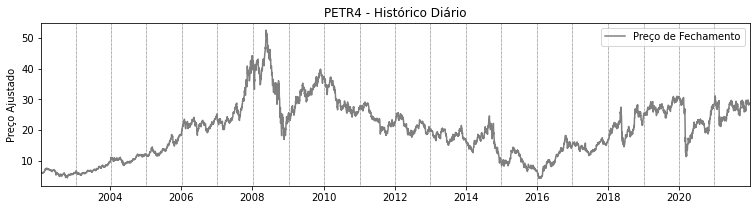

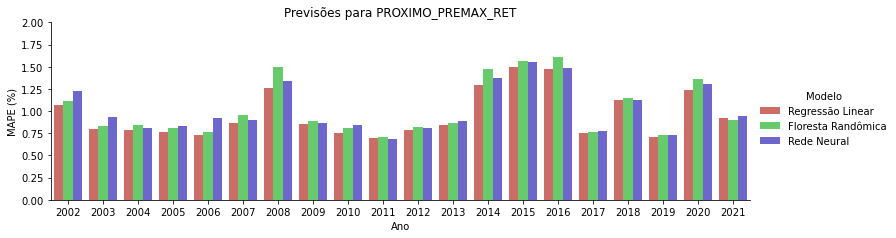

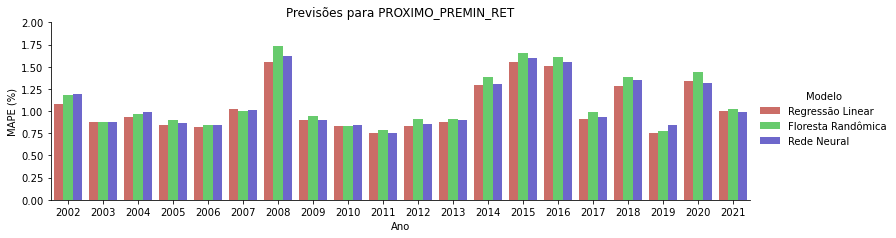

In [18]:
# histórico do preço para contextualizar momento histórico
plt.figure(figsize=(12.7, 3))
plt.plot(df_historico_ativo.index, df_historico_ativo['PREULT'], color='tab:gray', label='Preço de Fechamento')
for v in df_scores['data_fim']:
  plt.axvline(v, color='gray', linestyle=':', linewidth=0.5)
plt.title('PETR4 - Histórico Diário')
plt.ylabel('Preço Ajustado')
plt.legend()
plt.xlim(df_scores['data_inicio'].min(), df_scores['data_fim'].max())
plt.show();

# Desempenho das Previsões durante os testes - PROXIMO_PREMAX_RET
sns.catplot(data=df_scores, x='Ano', y='PROXIMO_PREMAX_RET', hue='Modelo', kind='bar', 
            height=3, aspect=3.5, palette='hls')
plt.ylabel('MAPE (%)')
plt.title('Previsões para PROXIMO_PREMAX_RET')
plt.ylim(0, 2)
plt.show();

# Desempenho das Previsões durante os testes - PROXIMO_PREMIN_RET
sns.catplot(data=df_scores, x='Ano', y='PROXIMO_PREMIN_RET', hue='Modelo', kind='bar', 
            height=3, aspect=3.5, palette='hls')
plt.ylabel('MAPE (%)')
plt.title('Previsões para PROXIMO_PREMIN_RET')
plt.ylim(0, 2)
plt.show();

### Processo completo gerar  Faixa de Negociação 

In [19]:
def aplicar_previsao(y_pred, indices, df_historico):
  '''Calcula PRED_PREMAX e PRED_PREMIN (Faixa de Negociação) a partir das previsões'''
  y_pred = pd.DataFrame(data=y_pred, columns=['PROXIMO_PREMIN_RET', 'PROXIMO_PREMAX_RET'], index=indices)
  # calcula faixa a partir dos percentuais previstos
  df_hist_extend = df_historico.loc[indices].join(y_pred)
  df_hist_extend['PRED_PREMAX'] = (1+df_hist_extend['PROXIMO_PREMAX_RET']) * df_hist_extend['PREMAX'].shift(+1)
  df_hist_extend['PRED_PREMIN'] = (1+df_hist_extend['PROXIMO_PREMIN_RET']) * df_hist_extend['PREMIN'].shift(+1)
  return df_hist_extend.dropna()
#----------------------------------------------------------------------------------

#### Pipeline Completo do Treinamento

In [20]:
codigo_ativo = 'PETR4'

# Importa dados da B3
df_historico = importar_dados_b3()
# Ajusta Desdobramentos de Ações
df_desdobramentos = importar_desdobramentos(DESDOBRAMENTOS_XLS)
# Seleciona apenas dados do ativo estudado
df_historico_ativo = get_historico_empresa(codigo_ativo, df_historico, df_desdobramentos)

# Transforma e Extrai Dados para Aprendizagem
X, y = extract_features_and_targets(df_historico_ativo)

# Separa dados para treino e para validação
X_train, y_train = X.loc[:'2020-08-31'], y.loc[:'2020-08-31']
X_valid, y_valid = X.loc['2021-09-01':], y.loc['2021-09-01':]

# Treina Modelo
model = LinearRegression()
model.fit(X, y);

Processando arquivo: COTAHIST_A2001.zip
Processando arquivo: COTAHIST_A2002.zip
Processando arquivo: COTAHIST_A2003.zip
Processando arquivo: COTAHIST_A2004.zip
Processando arquivo: COTAHIST_A2005.zip
Processando arquivo: COTAHIST_A2006.zip
Processando arquivo: COTAHIST_A2007.zip
Processando arquivo: COTAHIST_A2008.ZIP
Processando arquivo: COTAHIST_A2009.ZIP
Processando arquivo: COTAHIST_A2010.ZIP
Processando arquivo: COTAHIST_A2011.ZIP
Processando arquivo: COTAHIST_A2012.ZIP
Processando arquivo: COTAHIST_A2013.ZIP
Processando arquivo: COTAHIST_A2014.ZIP
Processando arquivo: COTAHIST_A2015.ZIP
Processando arquivo: COTAHIST_A2016.ZIP
Processando arquivo: COTAHIST_A2017.ZIP
Processando arquivo: COTAHIST_A2018.ZIP
Processando arquivo: COTAHIST_A2019.ZIP
Processando arquivo: COTAHIST_A2020.ZIP
Processando arquivo: COTAHIST_A2021.ZIP


#### Previsão e Cálculo da Faixa de Negociação

In [21]:
# Faz previsões
y_pred = model.predict(X_valid)

# Calcula Faixa de Negociação
df_faixa_negociacao = aplicar_previsao(y_pred, X_valid.index, df_historico_ativo)

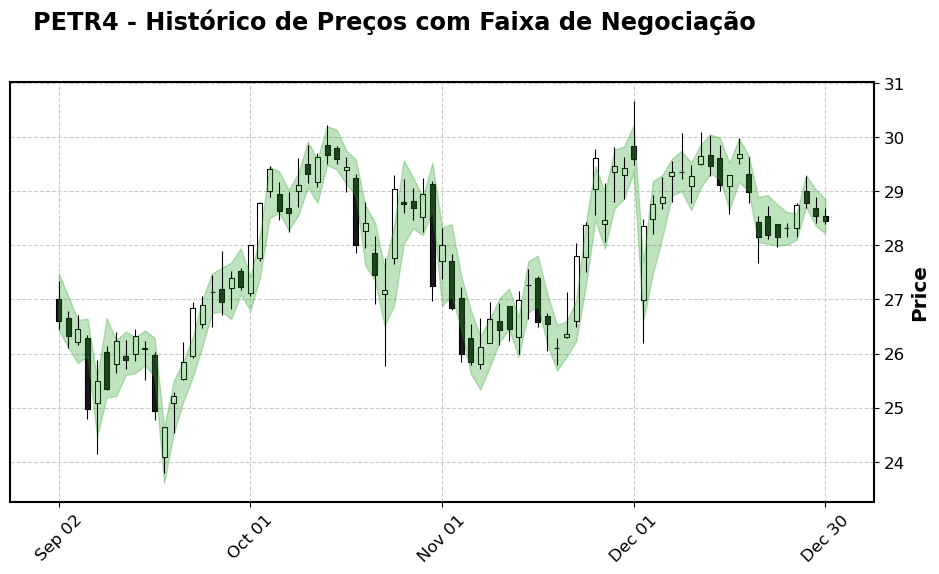

In [22]:
# exibe gráfico de preços de ações com Faixa de Negociação prevista
df_plot = df_faixa_negociacao.rename(columns={'PREABE': 'Open', 'PREULT': 'Close', 'PREMAX': 'High', 'PREMIN': 'Low' }).dropna()
mpf.plot(df_plot,
    type='candle',
    title='PETR4 - Histórico de Preços com Faixa de Negociação',
    style='classic',
    fill_between=dict(y1=df_plot['PRED_PREMAX'].values, y2=df_plot['PRED_PREMIN'].values, color='tab:green', alpha=0.3),
    figsize=(12,6),
)